# Optical Character Recognition

We will be doing the following:

0. Dependency and data setup
1. OCR with Otsu  
  i. Creating Otsu algorithm for image binarization  
  ii. Feeding Otsu output to Tesseract
2. Improving Otsu:  
  i. Using adaptive thresholding  
  ii. Background removal using variance  
  iii. Background removal using blurring    
  iv. Adaptive Gaussian thresholding
3. Image pre-processing for robust OCR  
  i.   Perspective transform  
  ii.  Skew correction  
  iii. Binarization  
  iv.  Noise removal  
  v.   Thinning  
  
  

## 0. Dependency and data setup

We will do the following:

i. Install relevant dependencies  
ii. Import the images we will be using for testing

### i. Importing dependencies

In [ ]:
! sudo apt install tesseract-ocr
! pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,668 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
import spacy
import math
import cv2

from PIL import ImageFilter, ImageEnhance
import PIL

import nltk
nltk.download('all')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

### ii. Loading the data

In [ ]:
# Creating function to load image
def load_img(path):
  img = PIL.Image.open(path).convert("L")
  img = np.asarray(img)
  return img

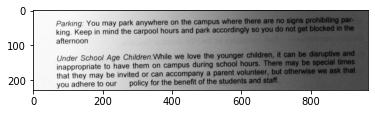

In [ ]:
img1 = load_img("/content/sample01.png")
plt.imshow(img1, cmap="gray")

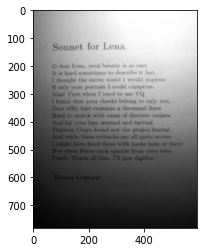

In [ ]:
img2 = load_img("/content/sample02.png")
plt.imshow(img2, cmap="gray")

## 1. OCR with Otsu

We will now do the following:  
i. Define our own function for Otsu thresholding  
ii. Utilize PyTesseract for character recognition

### i. Creating custom Otsu function

In [ ]:
# Creating function to check accuracy of OCR using cosine similarity
def accuracy(original, ocr):
  try: 
    # Tokenization 
    original_tokens = word_tokenize(original)  
    ocr_tokens = word_tokenize(ocr) 
      
    # Get list of english stopwords
    stop_words = stopwords.words('english')  
      
    # Extract any stopword present in either string 
    original_set = {w for w in original_tokens if not w in stop_words}  
    ocr_set = {w for w in ocr_tokens if not w in stop_words} 
      
    original_list =[]
    ocr_list =[] 
    # Create a set with keywords from both strings 
    union = original_set.union(ocr_set)  
    for w in union: 
        if w in original_set: original_list.append(1) # Initialize a new vector
        else: original_list.append(0) 

        if w in ocr_set: ocr_list.append(1) # Initialize a new vector
        else: ocr_list.append(0) 
    c = 0
      
    # Get cosine similarity 
    for i in range(len(union)): 
            c += original_list[i] * ocr_list[i] 
    cosine = c / float((sum(original_list)*sum(ocr_list))**0.5) 
    
    return cosine
  except:
    return 0.0

In [ ]:
# Creating Otsu functions

# To calculate and plot histogram of image
def get_histogram(img):
  hist, bins = np.histogram(img, 256, [0, 256])
  return hist, bins

def show_histogram(hist, bins):
  width = 0.7 * (bins[1] - bins[0])
  center = (bins[:-1] + bins[1:]) / 2
  plt.bar(center, hist, align='center', width=width)
  plt.show()

# To calculate total number of pixels in histogram
def get_pixel_count(histogram):
  total = 0
  for i in range(len(histogram)):
    total += histogram[i]
  return total

# To get sum of pixel probabilities in a given range
def get_probs(histogram, low, high, pixel_count):
  total = 0
  for r in range(low, high):
    total += histogram[r]/pixel_count
  return total

# To calculate mean of the pixels in a given range
def get_mean(histogram, low, high, pixel_count, probs):
  total = 0
  for r in range(low, high):
    total += (r * histogram[r] / pixel_count)
  total /= probs
  return total

# To calculate variance
def get_variance(histogram, low, high, pixel_count, probs, mean):
  total = 0
  for r in range(low, high):
    total += ((r - mean)**2) * (histogram[r] / pixel_count)
  total /= probs
  return total

# To get weighted class variance
def get_weighted_variance(histogram, low, high, pixel_count):
  q = get_probs(histogram, low, high, pixel_count)
  mean = get_mean(histogram, low, high, pixel_count, q)
  variance = get_variance(histogram, low, high, pixel_count, q, mean)

  return (variance**2) * q

# To get threshold value which minimzes intra class variance
def get_optimal_threshold(histogram):
  pixel_count = get_pixel_count(histogram)
  optimal_threshold = 0
  lowest_variance = -1
  for threshold in range(1, 256):
    try:
      weighted_variance_L = get_weighted_variance(histogram, 0, threshold, pixel_count)
      weighted_variance_R = get_weighted_variance(histogram, threshold+1, 256, pixel_count)
      weighted_variance_total = weighted_variance_L + weighted_variance_R
    except:
      continue

    # First iteration or lower variance value
    if lowest_variance == -1 or weighted_variance_total < lowest_variance:
      lowest_variance = weighted_variance_total
      optimal_threshold = threshold

  return optimal_threshold

# To threshold the given image
def threshold_image(img, threshold):
  img = (img > threshold) * 255
  return np.asarray(img, dtype=np.int32)

# Conduct Otsu thresholding on an image
def otsu(img, show_hist=False):
  hist, bins = get_histogram(img)
  threshold = get_optimal_threshold(hist.tolist())
  if show_hist:
    show_histogram(hist, bins)
    print(f"Image threshold: {threshold}")
  output = np.zeros_like(img)
  output[:,:] = threshold_image(img, threshold)
  return output

# Function to display an image
def display(img):
  plt.imshow(img, cmap="gray")

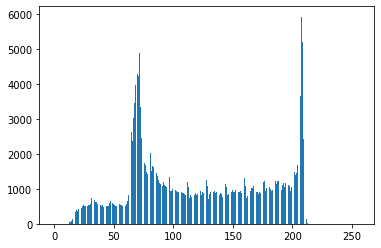

Image threshold: 127


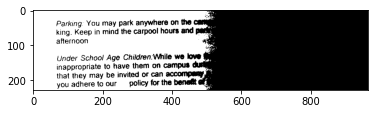

In [ ]:
# Thresholding the first image
otsu_img1 = otsu(img1, True)
display(otsu_img1)

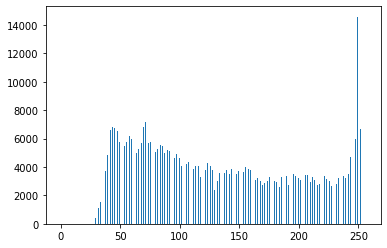

Image threshold: 143


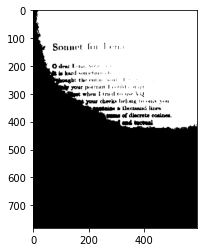

In [ ]:
# Thresholding the second image
otsu_img2 = otsu(img2, True)
display(otsu_img2)

We can see that the thresholding isn't able to binarize the text properly. This is because the images contain shadowy regions which skew the histograms and we can also see that the histograms aren't bimodal which is necessary for good Otsu threshodling.

### ii. Character recognition using PyTesseract

In [ ]:
# Noting down original texts for sample images
original_text_1 = "Parking: You may park anywhere on the campus where there are no signs prohibiting par- \n king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the afternoon \n\n Under School Age Children:While we love the younger children, it can be disruptive and \n inappropriate to have them on campus during school hours. There may be special times \n that they may be invited or can accompany a parent volunteer, but otherwise we ask \n that you adhere to our policy for the benefit of the students and staff."
original_text_2 = "Sonnet for Lena\n O dear Lena, your beauty is so vast \n It is hard sometimes to describe it fast. I thought the entire world I would impress \n If only your portrait I could compress. \n Alas! First when I tried to use VQ \n I found that your cheeks belong to only you. \n Your silky hair contains a thousand lines \n Hard to match with sums of discrete cosines. \n And for your lips, sensual and tactual \n Thirteen Crays found not the perfect fractal. \n And while these setbacks are all quite severe \n I might have fixed them with hacks here or there \n But when filters took sparkle from your eyes \n I said, 'Damn all this. I'll just digitize.' \n Thomas Colthurst"

In [ ]:
# Character recognition without Otsu thresholding
ocr_text_1 = pytesseract.image_to_string(img1)
print(f"First image:")
print(f"{ocr_text_1}")
print(f"Accuracy: {accuracy(original_text_1, ocr_text_1)}")

First image:
Parking: You may park anywhere on the ce
king. Keep in mind the carpool hours and park
afternoon

Under School Age Children:While we love
inappropriate to have them on campus @ )
that they may be invited or can accompany :
you adhere to our _ policy for the benefit of

 

Accuracy: 0.6998964726756152


In [ ]:
# Character recognition without Otsu thresholding
ocr_text_2 = pytesseract.image_to_string(img2)
print(f"Second image:")
print(f"{ocr_text_2}")
print(f"Accuracy: {accuracy(original_text_2, ocr_text_2)}")

Second image:
Sonnet for Lena

 

Accuracy: 0.17025130615174972


   
     
  

Parking: You may park anywhere on the can
king. Keep in mind the carpool hours and p
afternoon

Under School Age Children:While we love §
inappropriate to have them on campus Gurm
that they may be invited or can accompany,

you adhere to our —_policy for the benefit

   
    

  

   

Accuracy: 0.6998964726756152


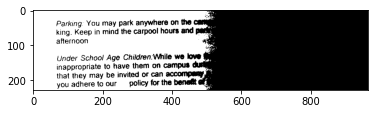

In [ ]:
# Character recognition with Otsu thresholding
otsu_img1 = otsu(img1)
display(otsu_img1)

ocr_otsu_text_1 = pytesseract.image_to_string(otsu_img1)
print(ocr_otsu_text_1)
print(f"Accuracy: {accuracy(original_text_1, ocr_otsu_text_1)}")

Perna

 

Accuracy: 0.0


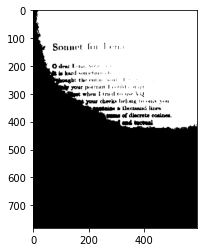

In [ ]:
# Character recognition with Otsu thresholding
plt.imshow(otsu_img2, cmap="gray")

ocr_otsu_text_2 = pytesseract.image_to_string(otsu_img2)
print(ocr_otsu_text_2)
print(f"Accuracy: {accuracy(original_text_2, ocr_otsu_text_2)}")

__Conclusion:__ The images without thresholding are able to produce average outputs while those with Otsu give either the same results or no results. This shows that the basic Otsu algorithm fails in instances of shadows in images or images with varying lightness.

## 2. Improving Otsu

We will improve the thresholding using the following 2 techniques:  
i. Adaptive thresholding  
ii. Background removal using variance  
iii. Background removal using blurring   
iv. Adaptive Gaussian thresholding

### i. OCR with adaptive thresholding

The problem we notice is that the global threshold may be a good global average but fails in certain areas of the image. Instead of taking a global threshold, we can break up the image into smaller blocks and conduct Otsu thresholding in these blocks, which will allow us to learn region-specific thresholds.

In [ ]:
def adaptive_otsu(img, row_block_size, col_block_size):
  assert col_block_size <= img.shape[1] and row_block_size <= img.shape[0]

  output = np.zeros_like(img)

  # Split the image into blocks and run Otsu
  for row in range(0, img.shape[0], row_block_size):
    for col in range(0, img.shape[1], col_block_size):
      row_start, row_end = row, min(img.shape[0], row+row_block_size)
      col_start, col_end = col, min(img.shape[1], col+col_block_size)

      block = img[row_start:row_end, col_start:col_end]
      otsu_block = otsu(block)
      output[row_start:row_end, col_start:col_end] = otsu_block

  return output

Parking: You may park anywhere on the campus where there are no signe prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under Schoo! Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours. There may be special times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our —_ policy for the benefit of the students and staff.

 

Accuracy: 0.9363821838346235


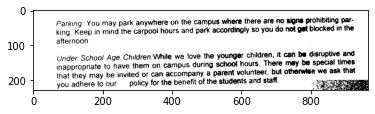

In [ ]:
# Character recognition with Otsu thresholding
adaptive_otsu_img1 = adaptive_otsu(img1, 100, 200)
display(adaptive_otsu_img1)

ocr_adaptive_otsu_text_1 = pytesseract.image_to_string(adaptive_otsu_img1)
print(ocr_adaptive_otsu_text_1)
print(f"Accuracy: {accuracy(original_text_1, ocr_adaptive_otsu_text_1)}")

 

h, Aer Dena, come benuty in so rant itediaaitsdll
Ty ig bard sounetiznes to deseribe it inst. ala

Tthaght the entire world} eculd impress
Lf omly vour portrait [ crak] rompreee.
Atagl! Pieat when f tricct tt tse VQ
L fomod that your checks belkng to ouly you.
Pulr alike hal? contains a Mion thee

i Herd to match with muitos of discrete cosines |
Aud for your fips, sensual and factual
Thigtees Crays found wut ibe proper fractal
And stile then sefhacks are all quite 9st

.. A might have fixed thea: with hacks here or there ,

Bait when Aliem took spagkle from your eves

Dandd, ‘Demo all thie. I'l just digitize.” mad

 

 

Accuracy: 0.27612404178634276


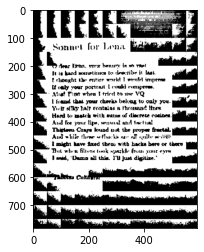

In [ ]:
# Character recognition with Otsu thresholding
adaptive_otsu_img2 = adaptive_otsu(img2, 50, 50)
display(adaptive_otsu_img2)

ocr_adaptive_otsu_text_2 = pytesseract.image_to_string(adaptive_otsu_img2)
print(ocr_adaptive_otsu_text_2)
print(f"Accuracy: {accuracy(original_text_2, ocr_adaptive_otsu_text_2)}")

__Conclusion:__ We see that adaptive thresholding is far superior to the initial Otsu algorithm for both images. We see that tesseract outputs almost the same text as there is in image 1. For image 2, we see that most of the text is not accurate since the thresholded image is very blurry and still noisy. We can also see that the block size depends on the image characteristics. This is why, we need to pre-process images before conducting OCR.

### ii. Background removal using variance

We see in the output for `sample02.png` that many background areas are thresholded to be black even though they are part of the background, just because of shadows. We can see that the variance in the small blocks which contain just the background are very low while the blocks with actual text have higher variance. We use this information to threshold the background. 

In [ ]:
def adaptive_otsu_with_bg(img, row_block_size, col_block_size, detect_bg=False, bg_thresh=50):
  assert col_block_size <= img.shape[1] and row_block_size <= img.shape[0]

  output = np.zeros_like(img)

  # Split the image into blocks and run Otsu
  for row in range(0, img.shape[0], row_block_size):
    for col in range(0, img.shape[1], col_block_size):
      row_start, row_end = row, min(img.shape[0], row+row_block_size)
      col_start, col_end = col, min(img.shape[1], col+col_block_size)

      block = img[row_start:row_end, col_start:col_end]
      otsu_block = otsu(block)

      if detect_bg:
        var = np.var(block)
        cv2_imshow(block)
        print(f"Variance: {var}")
        if var < bg_thresh:
          otsu_block.fill(255) # If variance is low, treat as background

      output[row_start:row_end, col_start:col_end] = otsu_block

  return output

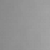

Variance: 50.5344


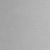

Variance: 48.64303616000001


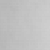

Variance: 36.31182016


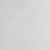

Variance: 22.42557184


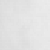

Variance: 15.058869760000002


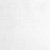

Variance: 23.67432896


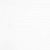

Variance: 1.7852160000000004


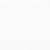

Variance: 0.9255801599999999


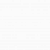

Variance: 0.9336422400000002


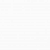

Variance: 0.999216


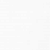

Variance: 0.9072486399999999


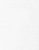

Variance: 3.6190674556213027


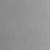

Variance: 48.37453056000001


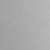

Variance: 44.84369600000001


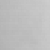

Variance: 31.162472959999995


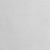

Variance: 21.38494976


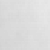

Variance: 21.161095039999996


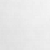

Variance: 23.81241536


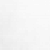

Variance: 13.781669760000002


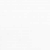

Variance: 1.40988096


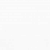

Variance: 0.9095545600000001


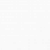

Variance: 0.6720838400000001


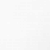

Variance: 3.2376953600000005


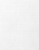

Variance: 9.040264036817883


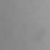

Variance: 43.966220160000006


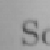

Variance: 282.3872070400001


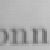

Variance: 467.23806399999995


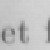

Variance: 497.4836294399999


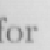

Variance: 479.6256


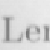

Variance: 569.01105856


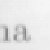

Variance: 373.20175104


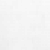

Variance: 5.38048704


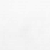

Variance: 5.99260416


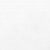

Variance: 4.830040959999999


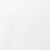

Variance: 13.30916544


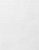

Variance: 10.820112031558185


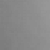

Variance: 40.85648064


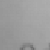

Variance: 78.4016


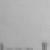

Variance: 120.43587264


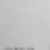

Variance: 68.57135296


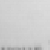

Variance: 111.11161600000001


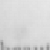

Variance: 179.82316736


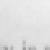

Variance: 116.73204416


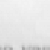

Variance: 143.11083776000004


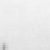

Variance: 56.353778559999995


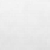

Variance: 28.02857664


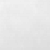

Variance: 23.94275584


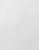

Variance: 24.383957922419466


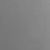

Variance: 41.90865599999999


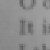

Variance: 143.727296


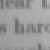

Variance: 277.89886976


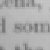

Variance: 311.20849599999997


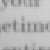

Variance: 347.55533504


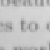

Variance: 296.28393664


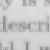

Variance: 328.03896576000005


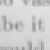

Variance: 298.12789504


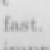

Variance: 234.14302400000003


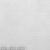

Variance: 64.738864


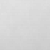

Variance: 29.28890624


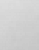

Variance: 32.162761341222875


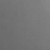

Variance: 36.94912256


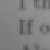

Variance: 134.92252416


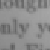

Variance: 229.83609344


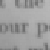

Variance: 283.64953856


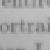

Variance: 284.24613056


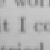

Variance: 307.88822016


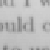

Variance: 310.79493824


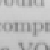

Variance: 346.36265664


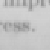

Variance: 193.07770624000003


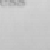

Variance: 54.570661759999986


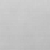

Variance: 28.707503999999993


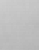

Variance: 31.13382879684418


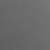

Variance: 23.33713664


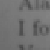

Variance: 105.20915135999999


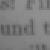

Variance: 176.15758015999998


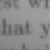

Variance: 225.62113536


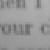

Variance: 227.77478336000001


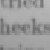

Variance: 314.46374656


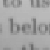

Variance: 303.20697535999994


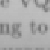

Variance: 297.26595584


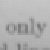

Variance: 290.29489856000004


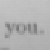

Variance: 202.74886336


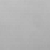

Variance: 29.85502976


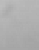

Variance: 33.60900880999342


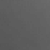

Variance: 17.257776


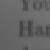

Variance: 101.78193600000002


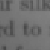

Variance: 135.19611584


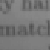

Variance: 148.78981824000002


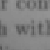

Variance: 184.62403776000002


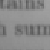

Variance: 218.82996224000001


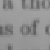

Variance: 259.06809856


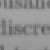

Variance: 273.29074176


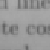

Variance: 222.12997823999999


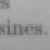

Variance: 250.11302400000002


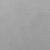

Variance: 30.402520959999993


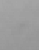

Variance: 20.52680710059171


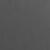

Variance: 14.788695040000004


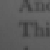

Variance: 72.84883136


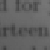

Variance: 122.45393599999998


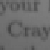

Variance: 118.90801343999999


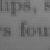

Variance: 141.76655616000002


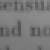

Variance: 183.96857024000002


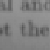

Variance: 186.49224895999998


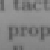

Variance: 231.32589824000001


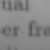

Variance: 205.83163136


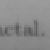

Variance: 197.77812736


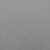

Variance: 45.66850816


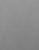

Variance: 50.545084549638396


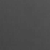

Variance: 13.52909504


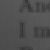

Variance: 52.73311424


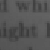

Variance: 88.158256


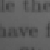

Variance: 94.61254656


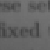

Variance: 112.1452


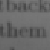

Variance: 134.13633536


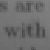

Variance: 144.96047296000003


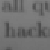

Variance: 151.590576


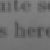

Variance: 132.12985600000002


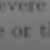

Variance: 107.10229504


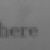

Variance: 116.61228736000001


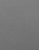

Variance: 26.383375147928994


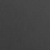

Variance: 11.85566464


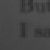

Variance: 39.44584896


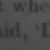

Variance: 62.26105536


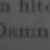

Variance: 83.97251776


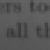

Variance: 83.27132864


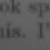

Variance: 89.75567615999998


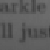

Variance: 111.97392384000001


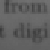

Variance: 116.60071424


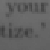

Variance: 96.05490944


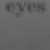

Variance: 45.03438016


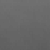

Variance: 25.167904640000003


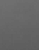

Variance: 23.199604470742933


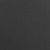

Variance: 10.16950464


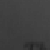

Variance: 29.920266240000004


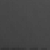

Variance: 21.748800000000003


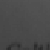

Variance: 44.45908224


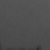

Variance: 27.76741376


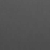

Variance: 20.056434559999996


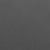

Variance: 20.68117696


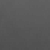

Variance: 23.704839039999996


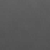

Variance: 19.669152639999997


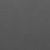

Variance: 18.36522496


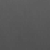

Variance: 20.137453439999998


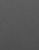

Variance: 19.25918316896778


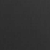

Variance: 10.005296


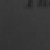

Variance: 12.017344


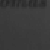

Variance: 20.07322304


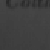

Variance: 18.769344000000004


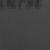

Variance: 25.11472896


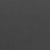

Variance: 7.938816


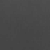

Variance: 8.528570239999999


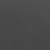

Variance: 10.12363456


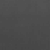

Variance: 13.12669376


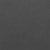

Variance: 11.62937024


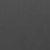

Variance: 10.72592384


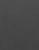

Variance: 12.156824194608806


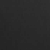

Variance: 7.18665216


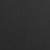

Variance: 11.530664960000001


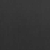

Variance: 12.422525440000001


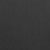

Variance: 11.851168640000001


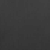

Variance: 11.06106624


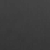

Variance: 16.564736


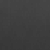

Variance: 15.122442239999998


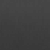

Variance: 19.362624


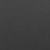

Variance: 18.540223360000002


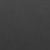

Variance: 20.257546240000003


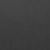

Variance: 18.89563136


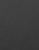

Variance: 14.226867587113741


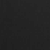

Variance: 3.8116761599999998


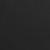

Variance: 5.60175296


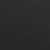

Variance: 7.80729024


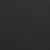

Variance: 8.12321024


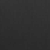

Variance: 9.91886016


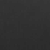

Variance: 8.656754560000001


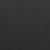

Variance: 12.732976


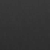

Variance: 13.0444


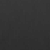

Variance: 10.139987839999998


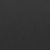

Variance: 9.702335360000001


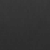

Variance: 12.53372096


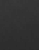

Variance: 10.84122130177515


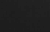

Variance: 2.2223734375000004


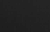

Variance: 3.5826937500000002


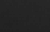

Variance: 2.7401109375


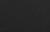

Variance: 3.1191937500000004


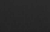

Variance: 4.04174375


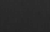

Variance: 3.5701734375000003


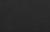

Variance: 3.9712437499999993


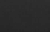

Variance: 3.7735999999999996


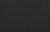

Variance: 4.3851234375


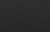

Variance: 4.534960937500001


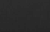

Variance: 3.6893109375000006


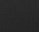

Variance: 3.825256307527943
ynnel for Lena

 

h Aer Dena, come benuty in so rant
Hy ie bard soineti:nes to deecribe it Laat.
Tthaght the entire world} eculd impress
Lf omly vour portrait [ crak] rompreee.
Atagl! Pieat when f tricct tt tse VQ
L fomod that your checks belkng to ouly you.
Pulr alike hal? contains a Mion thee
Hard to match with mums of discrete cosines.
Aud for your fips, sensual and factual
Thigtees Crays found wut ibe proper fractal «
And stile fhene sefhackc are all qaike ice
i might have fixed thea: with hacks here or there
6 when filiem took sparkle frou: your

wd, ‘Demo all this. I'l) just digitize.”

Accuracy: 0.31549666086411104


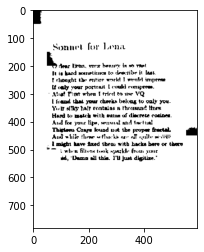

In [ ]:
# Character recognition with Otsu thresholding
adaptive_otsu_img2_with_bg = adaptive_otsu_with_bg(img2, 50, 50, True)
display(adaptive_otsu_img2_with_bg)

ocr_adaptive_otsu_text_2_with_bg = pytesseract.image_to_string(adaptive_otsu_img2_with_bg)
print(ocr_adaptive_otsu_text_2_with_bg)
print(f"Accuracy: {accuracy(original_text_2, ocr_adaptive_otsu_text_2_with_bg)}")

__Conclusion:__ We can see that there is an increase in the accuracy of the OCR and the thresholded image is also much clearer.

### iii. Background removal using blurring

We can also remove the background of the image which contains the shadows in order to get just the text on a white background

In [ ]:
def remove_bg(img, kernel_size=5):
  blurred_img = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)
  no_bg_img = blurred_img - img
  return no_bg_img

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly $0 you do not get blocked in the
afternoon

Under Schoo! Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during schoo! hours. There may be special times
that they may be invited or can accompany 4 parent volunteer, but otherwise we oak that
you adhere to our —_policy for the benefit of the students and staff.

 

Accuracy: 0.8757605390397141


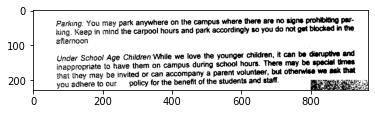

In [ ]:
# Character recognition with background removal and Adaptive Otsu
no_bg_img1 = remove_bg(img1, 1001)
remove_bg_img1 = adaptive_otsu(no_bg_img1, 100, 200)
display(remove_bg_img1)

ocr_remove_bg_text_1 = pytesseract.image_to_string(remove_bg_img1)
print(ocr_remove_bg_text_1)
print(f"Accuracy: {accuracy(original_text_1, ocr_remove_bg_text_1)}")

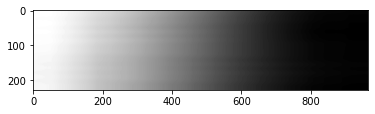

In [ ]:
# Showing extracted background
display(cv2.GaussianBlur(img1,(1001,1001),0))

 

O deer Lena, vour fesuty in ao vent

Te ia bard sanelinnes ta clescribe it baat,
Pthought the entire work! } wand impress
Hf only your portrait [euuhd comprenn.

Alas! Fire when I cciedt to nee VQ

[ fowod that your cheeks belong to only you.
Your silky bar coptainn @ thoussod lines
Hard to match with sume of discrete cosines.
And for your lips, setewal aid tactuad
Thirtern Crays found not the proper fractal,
And while thee setbacks arr all quile severe
I might have fixed them with hacks here or thers
Bet when filtem Look sparkle from your eyes
Deaid, ‘Doma all thie. I'll just digitive.”

 

Accuracy: 0.44416506919798654


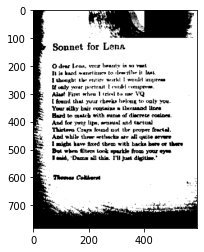

In [ ]:
# Character recognition with background removal and Adaptive Otsu
no_bg_img2 = remove_bg(img2, 801)
remove_bg_img2 = adaptive_otsu(no_bg_img2, 100, 200)
display(remove_bg_img2)

ocr_remove_bg_text_2 = pytesseract.image_to_string(remove_bg_img2)
print(ocr_remove_bg_text_2)
print(f"Accuracy: {accuracy(original_text_2, ocr_remove_bg_text_2)}")

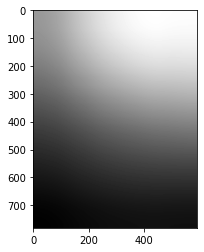

In [ ]:
# Showing extracted background
display(cv2.GaussianBlur(img2,(801,801),0))

__Conclusion:__ We can see that blurring is a better method for background removal than variance detection.

### iv. Adaptive Gaussian Thresholding

The adaptive gaussian thresholding algorithm takes a gaussian-weighted sum of the neighbourhood values minus the given constant __C__. This is better than even adaptive Otsu since it weighs the values of closer pixels more and guarantees a highly localised threshold.

In [ ]:
def adaptive_gaussian(img, block_size, C):
  thresholded = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
  return thresholded

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under School Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours. There may be special times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our policy for the benefit of the students and staff.

Accuracy: 1.0


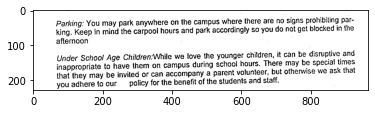

In [ ]:
# Character recognition with Adaptive Gaussian thresholding
adaptive_gaussian_img1 = adaptive_gaussian(img1, 13, 9)
display(adaptive_gaussian_img1)

ocr_adaptive_gaussian_text_1 = pytesseract.image_to_string(adaptive_gaussian_img1)
print(ocr_adaptive_gaussian_text_1)
print(f"Accuracy: {accuracy(original_text_1, ocr_adaptive_gaussian_text_1)}")

« Sonnet for Lena , °

O dear Lena, your benuty Ja oa vant

It is hard eometi:nes to deacribe It fast. |

L thought Lhe entire world [ would impress.

Lf onty your portrait [ could compress.

Alas! First when I tried to use VQ

L found that your checks belong to only you.
Your silky bait containa a thousand lines
Hard to match with sums of discrete cosines.
And for your lips, senrual and tactual

Thirteen Craya found not the proper fractal,
And while these setbacks are all quite severe
IT ohight bave fixed them with hacks bere or there
But when filters Look sprrkle from your eyes
Jeni, ‘Damo all thin. I'll Just digitize.”

Thomas Caltharst

Accuracy: 0.6490770196350103


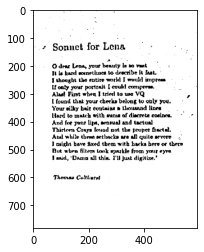

In [ ]:
# Character recognition with Adaptive Gaussian thresholding
adaptive_gaussian_img2 = adaptive_gaussian(img2, 37, 4)
display(adaptive_gaussian_img2)

ocr_adaptive_gaussian_text_2 = pytesseract.image_to_string(adaptive_gaussian_img2)
print(ocr_adaptive_gaussian_text_2)
print(f"Accuracy: {accuracy(original_text_2, ocr_adaptive_gaussian_text_2)}")

__Conclusion:__ We can see a drastic improvement in the thresholding as well as the accuracy of the detected text.

## 3. More robust character recognition

In the real world, the images may suffer from several different types of image degradation. Even with a really good OCR algorithm, we may get a bad OCR accuracy just because of the image degradation. To take care of this, image pre-processing must be done. <br> <br>

These pre-processing steps include

1. **Perspective Transform**: A common problem is that most images are taken at an angle from the actual plane of the paper. This means that the text is not horizontal in the image which can sometimes confuse the OCR algorithm. We will apply automatic perspective transformation to ensure that most images are transformed from a 3D plane to a 2D plane.

2. **Skew Correction**: Image obtained from the previous stage may not be correctly oriented, it may be aligned at any angle. So we need to perform skew correction to make sure that the image forwarded to subsequent stages is correctly oriented.

3. **Binarization:** It means converting a Coloured image to Binary image (containing only black & white colours). Usually, in practice, this conversion of Coloured image to Binary image is done by an intermediate GrayScale image. [This step has already been done using the Otsu thresholding algorithm]

4. **Speckle Noise Removal:** Noise (small dots or foreground components) may be introduced easily into an image while scanning it during Image Acquisition because of various reasons like low clarity camera, a shadow on image etc. This noise should be removed so that the image will be clean and uniform.

5. **Thinning:** Different images have text with different width of strokes. This variability is very high in the case of handwritten words. Skeletonization is a technique, using which we can make all strokes to have a uniform width (Maybe 1 pixel wide or few pixels wide)



### 3.1 Perspective transform



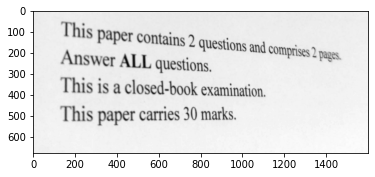

In [ ]:
# Loading a 3D perspective image
paper = load_img("/content/paper.jpeg")
display(paper)

In [ ]:
# Noting down original text for image
original_text_paper = "This paper contains 2 questions and comprises 2 pages. \n Answer ALL questions. \n This is a closed-book examination. \n This paper carries 30 marks"

   
 
  

1 . ey 3 i ; a Seah f
his Paper contains ? questio

Answer ALL questions.
This is a closed-book examination. 3
This paper carries 30 marks. jugpsersimeni

s
gg. =: a
an be =

NS and comprises ? pages,

Accuracy: 0.6712486220795378


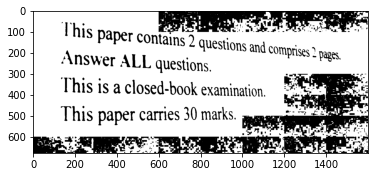

In [ ]:
# Conducting thresholding and OCR on image
adaptive_otsu_paper = adaptive_otsu(paper, 100, 200)
display(adaptive_otsu_paper)

ocr_adaptive_otsu_paper = pytesseract.image_to_string(adaptive_otsu_paper)
print(ocr_adaptive_otsu_paper)
print(f"Accuracy: {accuracy(original_text_paper, ocr_adaptive_otsu_paper)}")

In [ ]:
def perspective_transform(img, corners):
  (tl, tr, br, bl) = corners

  # Compute width of new image
  width_top = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2)) # Distance between top right and left 
  width_bottom = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2)) # Distance between bottom right and left
  width = max(int(width_top), int(width_bottom)) # Maximum of above 2

  # Compute height of new image
  height_left = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2)) # Distance between left top and bottom
  height_right = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2)) # Distance between right top and bottom
  height = max(int(height_right), int(height_left))
    
  # Creating points to map corner points to in new image
  corners_new = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]], dtype = "float32")
 
  # Compute perspective transform matrix and transform image
  transform_matrix = cv2.getPerspectiveTransform(corners, corners_new)
  transformed_image = cv2.warpPerspective(img, transform_matrix, (width, height))

  return transformed_image

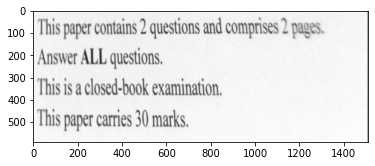

In [ ]:
paper_corners = np.asarray([(100, 10), (1600, 180), (1600, 550), (100, 600)], dtype = "float32")
transformed_paper = perspective_transform(paper, paper_corners)
display(transformed_paper)

This paper contains 2 questions and comprises 2 pages.
Answer ALL questions. era
This is a closed-book examination. |
This paper carries 30 marks,  &

   

 

Accuracy: 0.8885233166386385


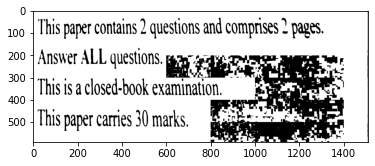

In [ ]:
# Conducting thresholding and OCR on image
adaptive_otsu_paper_transformed = adaptive_otsu(transformed_paper, 100, 200)
display(adaptive_otsu_paper_transformed)

ocr_adaptive_otsu_paper_transformed = pytesseract.image_to_string(adaptive_otsu_paper_transformed)
print(ocr_adaptive_otsu_paper_transformed)
print(f"Accuracy: {accuracy(original_text_paper, ocr_adaptive_otsu_paper_transformed)}")

__Conclusion:__ As we can see, the image without the transformation was not recognised properly since the OCR algorithm is created for 2D planar text. After we conducted perspective transform on the image, the recognised text is a lot more accurate.

### 3.2 Image de-skewing



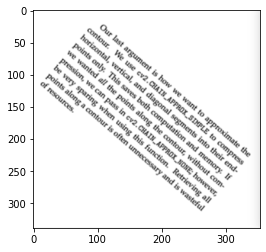

In [ ]:
#Loading a 2D-skewed image
skewed_paper = load_img("/content/skewedpaper.png")
display(skewed_paper)

In [ ]:
# Noting down original text for image
original_text_skewed = "Our last argument is how we want to approximate the contour. We use cv2.CHAIN_APPROX_SIMPLE to compress horizontal, vertical, and diagonal segments into their endpoints only. This saves both computation and memory. If we wanted all the points along the contour, without compression, we can pass in cv2.CHAIN_APPROX_NONE; however, be very sparing when using this function. Retrieving all points along a contour is often unnecessary and is wasteful of resources."


Accuracy: 0.0


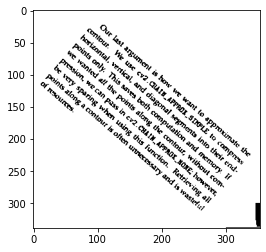

In [ ]:
# Conducting thresholding and OCR on image
adaptive_otsu_paper_skewed = adaptive_otsu(skewed_paper, 300, 300)
display(adaptive_otsu_paper_skewed)

ocr_adaptive_otsu_paper_skewed = pytesseract.image_to_string(adaptive_otsu_paper_skewed)
print(ocr_adaptive_otsu_paper_skewed)
print(f"Accuracy: {accuracy(original_text_skewed, ocr_adaptive_otsu_paper_skewed)}")

In [ ]:
#Defining the deskew functions

# Calculate skew angle of an image
def getSkewAngle(cvImage):
  
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    blur = cv2.GaussianBlur(newImage, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle


# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)    

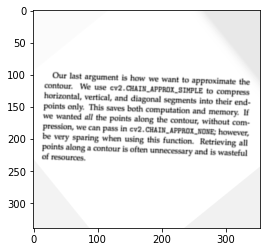

In [ ]:
deskewed_paper = deskew(skewed_paper)
display(deskewed_paper)

Dur last argument is how we want to approslinate the
fonlaus. We use c¥2.CHAIH_APPRUX,SINPLE to compnss
harizonial, vertical, and diagonal segments into their end
Points only. This saves both computation andl memory. It
we wanted ell the points slong the conlaut, without com:
Prrasion, we can pass in cv2. CHAIR. APPROZ_ ROME; howeves,
be very sparing when using this function. Retrieving all
Points along a contour is often unnecessary and is wasteful
of resources.

—_ @a

Accuracy: 0.6378635118111463


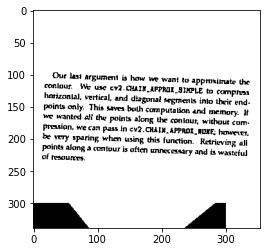

In [ ]:
# Conducting thresholding and OCR on image
adaptive_otsu_paper_deskewed = adaptive_otsu(deskewed_paper, 300, 300)
display(adaptive_otsu_paper_deskewed)

ocr_adaptive_otsu_paper_deskewed = pytesseract.image_to_string(adaptive_otsu_paper_deskewed)
print(ocr_adaptive_otsu_paper_deskewed)
print(f"Accuracy: {accuracy(original_text_skewed, ocr_adaptive_otsu_paper_deskewed)}")

### 3.4 Removing Speckle Noise



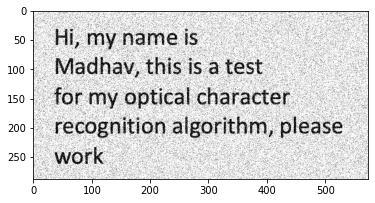

In [ ]:
#Loading a speckled image
speckle = load_img("/content/noise2.png")
display(speckle)

In [ ]:
# Noting down original text for image
original_text_noise = "Hi, my name is Madhav, this is a test for my optical character recognition algorithm; please work"

Hi, myname is

~ Madhary, this is a test
for my optical character

“recognition algorithm, pleas
work eee

 
  
 
  

Accuracy: 0.6172133998483676


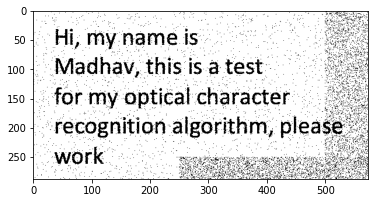

In [ ]:
# Conducting thresholding and OCR on image
adaptive_otsu_speckle = adaptive_otsu(speckle, 250, 250)
display(adaptive_otsu_speckle)

ocr_adaptive_otsu_speckle = pytesseract.image_to_string(adaptive_otsu_speckle)
print(ocr_adaptive_otsu_speckle)
print(f"Accuracy: {accuracy(original_text_noise, ocr_adaptive_otsu_speckle)}")

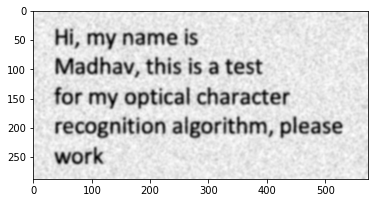

In [ ]:
#Removing noise using cv2 gaussian filter
gaussian_speckle = cv2.GaussianBlur(speckle, (9, 9), 0)

# Plotting of image after Gaussian Filter
display(gaussian_speckle) 
plt.show()

Hi, my name is

Madhav, this is a test

for my optical character
recognition algorithm, please

work FRYE IWR

Accuracy: 0.8807048459279793


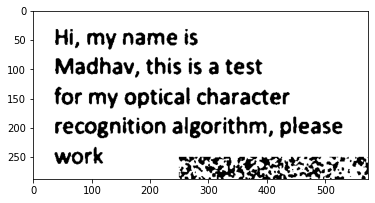

In [ ]:
# Conducting thresholding and OCR on image
adaptive_otsu_gaussian = adaptive_otsu(gaussian_speckle, 250, 250)
display(adaptive_otsu_gaussian)

ocr_adaptive_otsu_gaussian = pytesseract.image_to_string(adaptive_otsu_gaussian)
print(ocr_adaptive_otsu_gaussian)
print(f"Accuracy: {accuracy(original_text_noise, ocr_adaptive_otsu_gaussian)}")

As it can be clearly seen, the output after removing noise using the Gaussian filter is much clearer than without removing it.


### 3.5 Thinning 

Thinning in OCR is required mostlly with handwritten documents, when the text is too thick and thus some characters overlap with the others. Thinning reduces the width of each character, thus reducing the overlap and making it easier for the OCR algorithm to detect indivudual characters

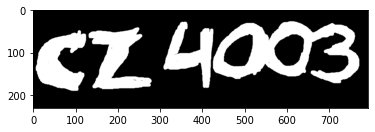

In [ ]:
#Loading a speckled image
comp1 = load_img("/content/cz40032.png")
# comp1 = cv2.rotate(comp1, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(comp1, cmap="gray")

In [ ]:
# Noting down original text for image
original_text_thin = "CZ 4003"

CZ 4O03

Accuracy: 0.5


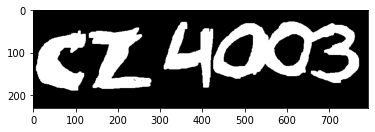

In [ ]:
# Conducting thresholding and OCR on image
adaptive_otsu_thin = adaptive_otsu(comp1, 50, 50)
display(adaptive_otsu_thin)

ocr_adaptive_otsu_thin = pytesseract.image_to_string(adaptive_otsu_thin)
print(ocr_adaptive_otsu_thin)
print(f"Accuracy: {accuracy(original_text_thin, ocr_adaptive_otsu_thin)}")

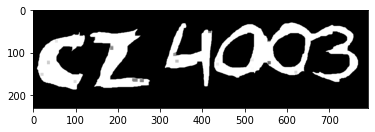

In [ ]:
kernel = np.ones((7,7),np.uint8)
thinned_comp1 = cv2.erode(comp1, kernel,iterations = 1)

display(thinned_comp1)

CZ 4003

Accuracy: 1.0


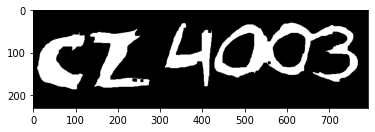

In [ ]:
# Conducting thresholding and OCR on image
adaptive_otsu_thinned = adaptive_otsu(thinned_comp1, 50, 50)
display(adaptive_otsu_thinned)

ocr_adaptive_otsu_thinned = pytesseract.image_to_string(adaptive_otsu_thinned)
print(ocr_adaptive_otsu_thinned)
print(f"Accuracy: {accuracy(original_text_thin, ocr_adaptive_otsu_thinned)}")